Collection count: 419


/home/sarim.hashmi/Downloads/RAG_basic_project/rag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


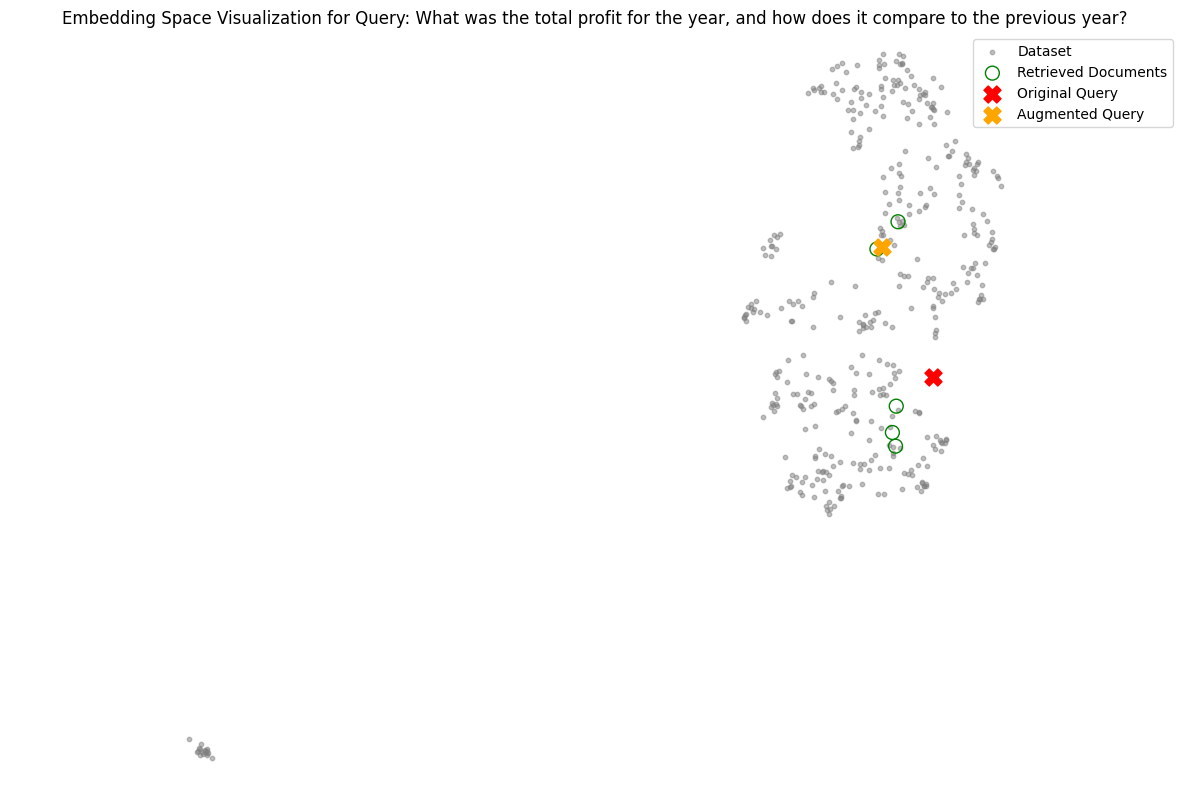

Visualization complete. Check the output for the plot.


In [3]:
from utils.helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from dotenv import load_dotenv
from groq import Groq
import chromadb
from chromadb.utils import embedding_functions
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from sentence_transformers import SentenceTransformer
from pypdf import PdfReader
import umap
from datetime import datetime
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

# Initialize clients and models
client = Groq(api_key=groq_api_key)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
reader = PdfReader("asset/microsoft-annual-report.pdf")

# Extract text from PDF
pdf_texts = [p.extract_text().strip() for p in reader.pages]
pdf_texts = [text for text in pdf_texts if text]

# Text splitting
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

# Set up Chroma
embedding_function = SentenceTransformerEmbeddingFunction()
chroma_client = chromadb.Client()

# Create a unique collection name
unique_collection_name = f"microsoft-collection-{datetime.now().strftime('%Y%m%d%H%M%S')}"

# Create or get the collection
chroma_collection = chroma_client.create_collection(
    unique_collection_name,
    embedding_function=embedding_function,
    get_or_create=True
)

# Add documents to the collection
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
print(f"Collection count: {chroma_collection.count()}")

# Define query and retrieve documents
query = "What was the total revenue for the year?"
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

# for document in retrieved_documents:
#     print(word_wrap(document))
#     print("\n")

def augment_query_generated(question):
    prompt = """You are a helpful expert financial research assistant. 
   Provide an example answer to the given question, that might be found in a document like an annual report."""
    
    response = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": question,
            },
        ],
    )
    content = response.choices[0].message.content
    return content

original_query = "What was the total profit for the year, and how does it compare to the previous year?"
hypothetical_answer = augment_query_generated(original_query)
joint_query = f"{original_query} {hypothetical_answer}"

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]

# Prepare embeddings for visualization
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)

# Visualize the embeddings
plt.figure(figsize=(12, 8))

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    alpha=0.5,
    label="Dataset"
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
    label="Retrieved Documents"
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
    label="Original Query"
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
    label="Augmented Query"
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"Embedding Space Visualization for Query: {original_query}")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

print("Visualization complete. Check the output for the plot.")